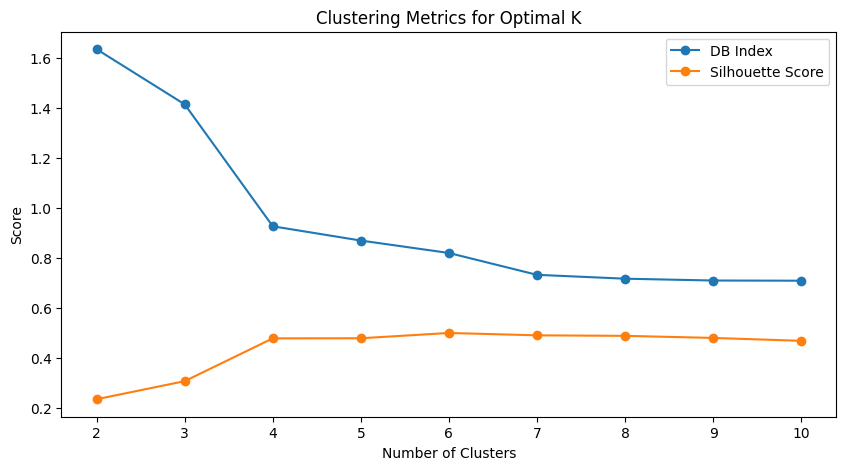

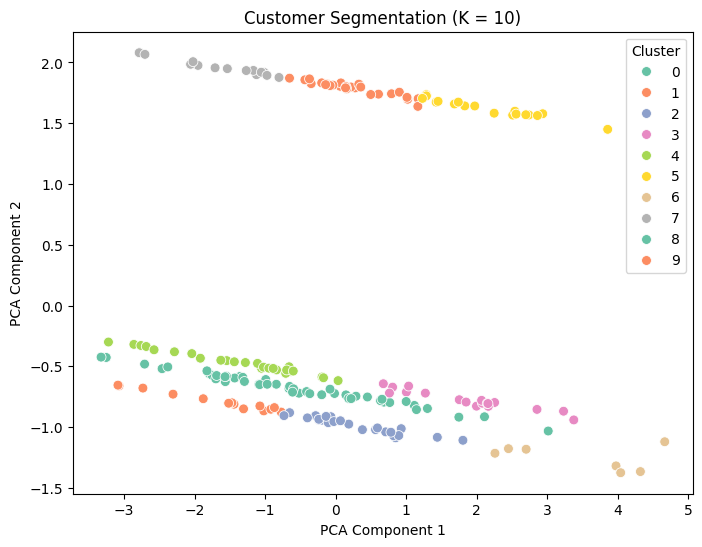

(10, 0.7097025557024883, 0.500693030783354)

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

customers_df = pd.read_csv('/content/Customers.csv')
transactions_df = pd.read_csv('/content/Transactions.csv')

merged_data = transactions_df.merge(customers_df, on="CustomerID", how="inner")
customer_transactions = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "TransactionID": "count",
    "Quantity": "sum"
}).rename(columns={"TransactionID": "TotalTransactions", "TotalValue": "TotalSpend"})

customer_profile = customers_df.set_index("CustomerID")[["Region"]]
customer_profile = pd.get_dummies(customer_profile, columns=["Region"])

customer_data = customer_transactions.join(customer_profile)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

db_indices = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init="k-means++")
    clusters = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, clusters)
    silhouette_avg = silhouette_score(scaled_data, clusters)

    db_indices.append(db_index)
    silhouette_scores.append(silhouette_avg)

optimal_clusters = cluster_range[np.argmin(db_indices)]

final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10, init="k-means++")
final_clusters = final_kmeans.fit_predict(scaled_data)

customer_data["Cluster"] = final_clusters

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
customer_data["PCA1"] = pca_data[:, 0]
customer_data["PCA2"] = pca_data[:, 1]

plt.figure(figsize=(10, 5))
plt.plot(cluster_range, db_indices, marker='o', label="DB Index")
plt.plot(cluster_range, silhouette_scores, marker='o', label="Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Clustering Metrics for Optimal K")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_data, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=50)
plt.title(f"Customer Segmentation (K = {optimal_clusters})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

optimal_clusters, min(db_indices), np.max(silhouette_scores)
